In [1]:
# 전이 학습 - VGG16을 활용
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 기존의 이미지의 갯수를 늘리는 작업 : 데이터 전처리
train_datagen=ImageDataGenerator(rescale=1./255,   # 정규화
                   horizontal_flip=True, # 수평으로 뒤집기
                   width_shift_range=0.1, # 수평이동
                   height_shift_range=0.1, # 수직이동
                   fill_mode='nearest')  # 빈 공간 채우는 방법
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory('./data/data/chap20-data/train',   # 학습셋이 있는 폴더의 위치
                                                target_size=(150,150), batch_size=5, class_mode='binary')

test_generator= test_datagen.flow_from_directory('./data/data/chap20-data/test',   # 학습셋이 있는 폴더의 위치
                                                target_size=(150,150), batch_size=5, class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [3]:
transfer_model = VGG16(input_shape=(150,150,3), include_top=False)
transfer_model.trainable =False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [5]:
# VGG16 모델을 연결
model = Sequential()
model.add(transfer_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# 컴파일 옵션
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 조기 중간점 설정
early_stopping = EarlyStopping(patience=5)

# 모델 실행
history = model.fit(train_generator, epochs=30, validation_data=test_generator, validation_steps=10, callbacks=[early_stopping])

Epoch 1/30
32/32 [==============================] - 16s 461ms/step - loss: 0.7881 - accuracy: 0.5188 - val_loss: 0.6664 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 15s 458ms/step - loss: 0.6145 - accuracy: 0.6375 - val_loss: 0.4994 - val_accuracy: 0.8000
Epoch 3/30
32/32 [==============================] - 16s 495ms/step - loss: 0.4705 - accuracy: 0.7937 - val_loss: 0.4513 - val_accuracy: 0.8800
Epoch 4/30
32/32 [==============================] - 16s 493ms/step - loss: 0.3833 - accuracy: 0.8813 - val_loss: 0.3812 - val_accuracy: 0.8800
Epoch 5/30
32/32 [==============================] - 17s 519ms/step - loss: 0.3426 - accuracy: 0.8625 - val_loss: 0.2982 - val_accuracy: 0.9600
Epoch 6/30
32/32 [==============================] - 17s 529ms/step - loss: 0.3400 - accuracy: 0.8813 - val_loss: 0.2737 - val_accuracy: 0.9600
Epoch 7/30
32/32 [==============================] - 17s 538ms/step - loss: 0.2949 - accuracy: 0.9000 - val_loss: 0.2833 - val_accuracy: 0.9000

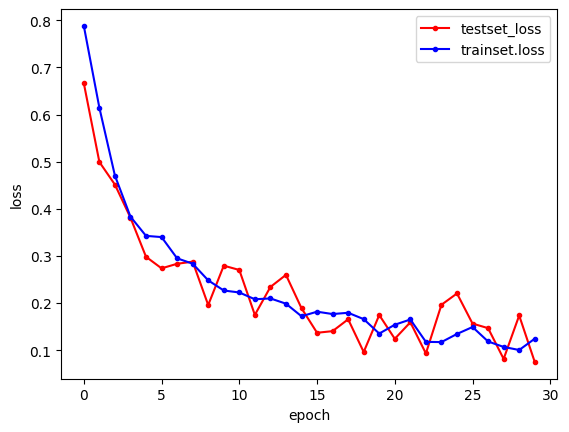

In [8]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len= np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='trainset.loss')

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()